In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%qtconsole --colors=linux
plt.style.use('ggplot')

from matplotlib import gridspec
from theano import tensor as tt
from scipy import stats

# Chapter 16 - The BART model of risk taking

## 16.1 The BART model
Balloon Analogue Risk Task (BART: Lejuez et al., 2002): Every trial in this task starts by showing a balloon representing a small monetary value. The subject can then either transfer the money to a virtual bank account, or choose to pump, which adds a small amount of air to the balloon, and increases its value. There is some probability, however, that pumping the balloon will cause it to burst, causing all the money to be lost. A trial finishes when either the subject has transferred the money, or the balloon has burst.

$$ \gamma^{+} \sim \text{Uniform}(0,10) $$
$$ \beta \sim \text{Uniform}(0,10) $$
$$ \omega = -\gamma^{+} \,/\,\text{log}(1-p) $$
$$ \theta_{jk} = \frac{1} {1+e^{\beta(k-\omega)}} $$
$$ d_{jk} \sim \text{Bernoulli}(\theta_{jk}) $$

In [2]:
p = .15  # (Belief of) bursting probability
ntrials = 90   # Number of trials for the BART

Data = pd.read_csv('data/GeorgeSober.txt', sep='\t')
# Data.head()
cash = np.asarray(Data['cash']!=0, dtype=int)
npumps = np.asarray(Data['pumps'], dtype=int)

options = cash + npumps

d = np.full([ntrials,30], np.nan)
k = np.full([ntrials,30], np.nan)
# response vector
for j, ipumps in enumerate(npumps):
    inds = np.arange(options[j],dtype=int)
    k[j,inds] = inds+1
    if ipumps > 0:
        d[j,0:ipumps] = 0
    if cash[j] == 1:
        d[j,ipumps] = 1
        
indexmask = np.isfinite(d)
d = d[indexmask]
k = k[indexmask]

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 188.67:   2%|▏         | 4831/200000 [00:01<01:51, 1746.00it/s]
Convergence archived at 5000
Interrupted at 5,000 [2%]: Average Loss = 207.65
100%|██████████| 3500/3500.0 [00:10<00:00, 339.71it/s]


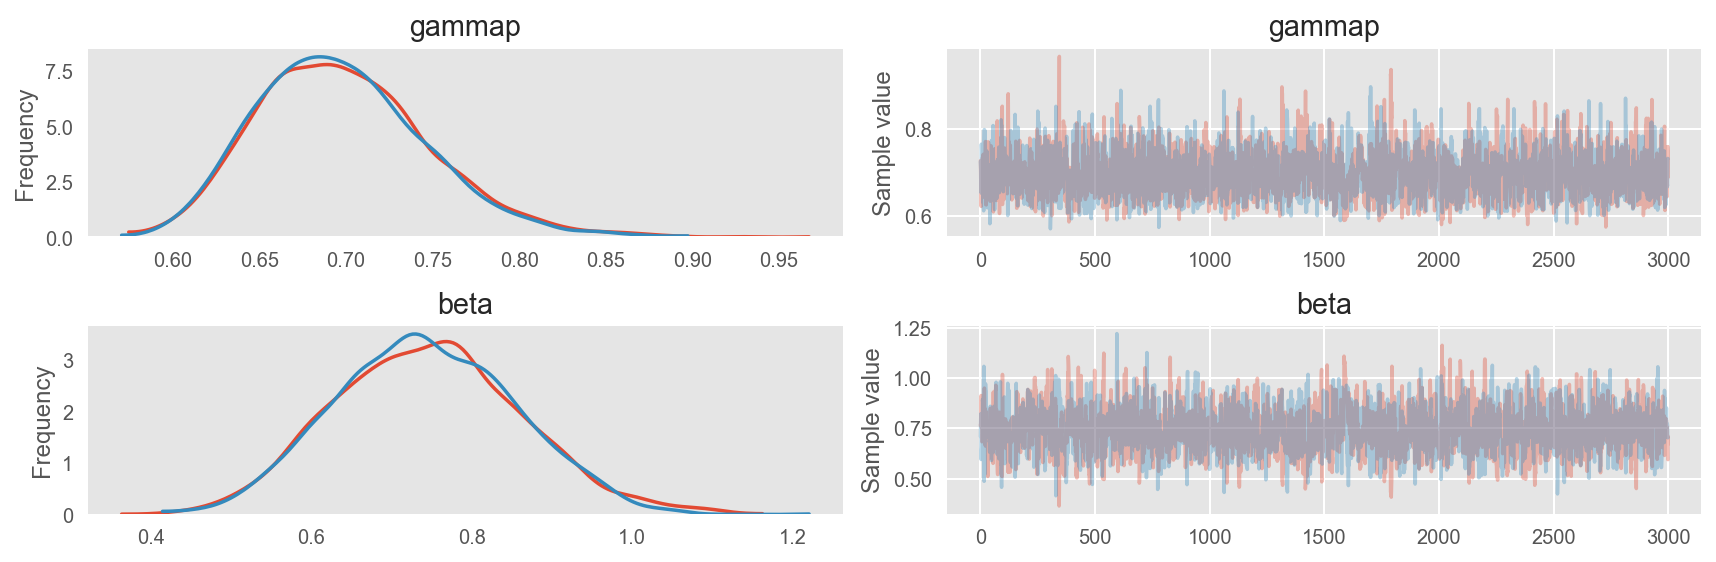

In [3]:
with pm.Model():
    gammap = pm.Uniform('gammap', lower=0, upper=10, testval=1.2)
    beta = pm.Uniform('beta', lower=0, upper=10, testval=.5)
    omega = pm.Deterministic('omega', -gammap/np.log(1-p))
    
    thetajk = 1 - pm.math.invlogit(- beta * (k - omega))
    
    djk = pm.Bernoulli('djk', p=thetajk, observed=d)
    
    trace = pm.sample(3e3, njobs=2)
    
pm.traceplot(trace, varnames=['gammap', 'beta'])
plt.show()

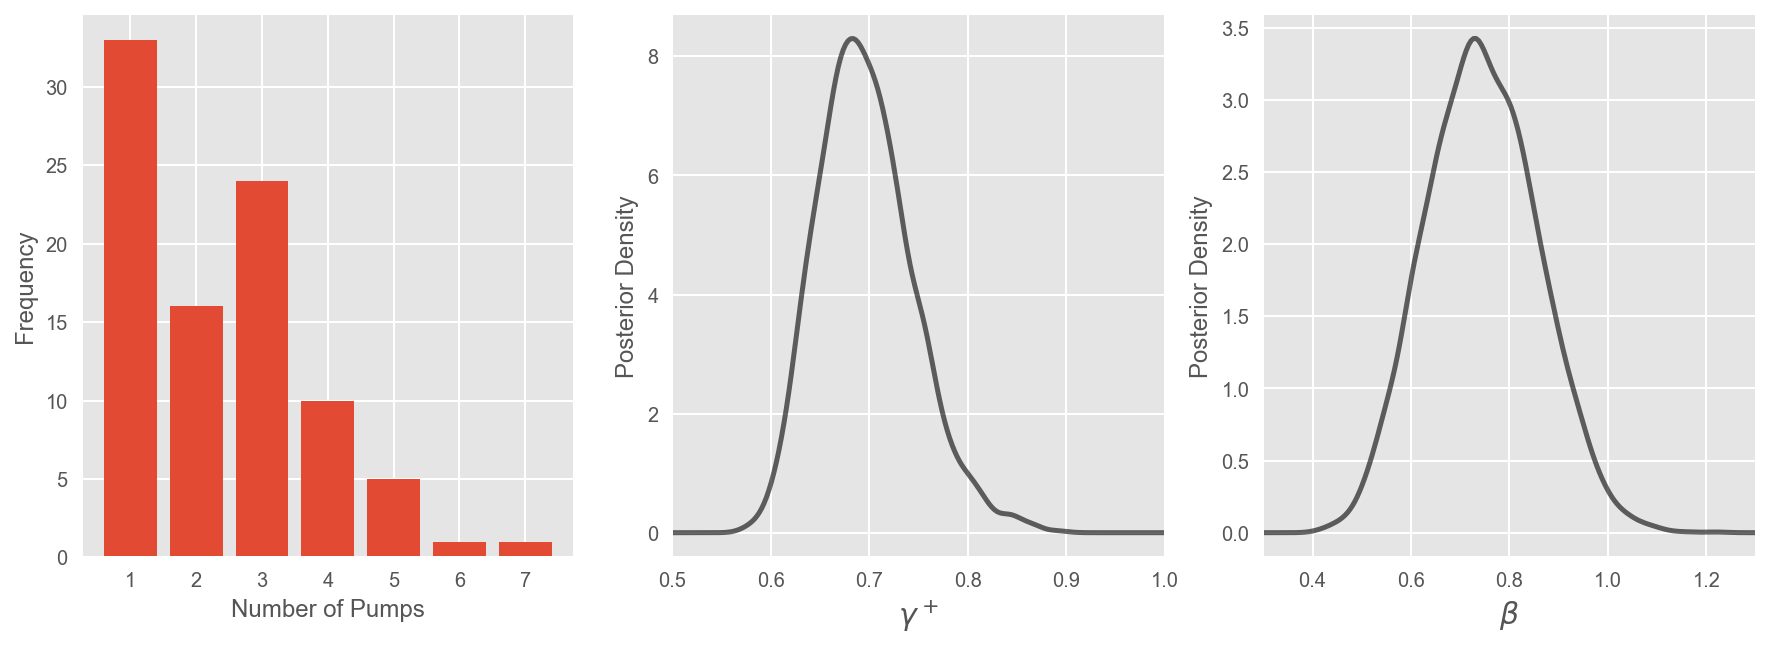

In [4]:
from scipy.stats.kde import gaussian_kde
burnin=2000
gammaplus = trace['gammap'][burnin:]
beta = trace['beta'][burnin:]

fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 3)

ax0 = plt.subplot(gs[0])
ax0.hist(npumps, bins=range(1, 9), rwidth=.8, align='left')
plt.xlabel('Number of Pumps', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

ax1 = plt.subplot(gs[1])
my_pdf1 = gaussian_kde(gammaplus)
x1=np.linspace(.5, 1, 200)
ax1.plot(x1, my_pdf1(x1), 'k', lw=2.5, alpha=0.6) # distribution function
plt.xlim((.5, 1))
plt.xlabel(r'$\gamma^+$', fontsize=15)
plt.ylabel('Posterior Density', fontsize=12)

ax2 = plt.subplot(gs[2])
my_pdf2 = gaussian_kde(beta)
x2=np.linspace(0.3, 1.3, 200)
ax2.plot(x2, my_pdf2(x2), 'k', lw=2.5, alpha=0.6,) # distribution function
plt.xlim((0.3, 1.3))
plt.xlabel(r'$\beta$', fontsize=15)
plt.ylabel('Posterior Density', fontsize=12)

plt.show()

## 16.2 A hierarchical extension of the BART model
  
  
$$ \mu_{\gamma^{+}} \sim \text{Uniform}(0,10) $$
$$ \sigma_{\gamma^{+}} \sim \text{Uniform}(0,10) $$
$$ \mu_{\beta} \sim \text{Uniform}(0,10) $$
$$ \sigma_{\beta} \sim \text{Uniform}(0,10) $$
$$ \gamma^{+}_i \sim \text{Gaussian}(\mu_{\gamma^{+}}, 1/\sigma_{\gamma^{+}}^2) $$
$$ \beta_i \sim \text{Gaussian}(\mu_{\beta}, 1/\sigma_{\beta}^2) $$
$$ \omega_i = -\gamma^{+}_i \,/\,\text{log}(1-p) $$
$$ \theta_{ijk} = \frac{1} {1+e^{\beta_i(k-\omega_i)}} $$
$$ d_{ijk} \sim \text{Bernoulli}(\theta_{ijk}) $$

In [5]:
p = .15  # (Belief of) bursting probability
ntrials = 90   # Number of trials for the BART
Ncond = 3

dall = np.full([Ncond,ntrials,30], np.nan)
options = np.zeros((Ncond,ntrials))
kall = np.full([Ncond,ntrials,30], np.nan)
npumps_ = np.zeros((Ncond,ntrials))

for icondi in range(Ncond):
    if icondi == 0:
        Data = pd.read_csv('data/GeorgeSober.txt',sep='\t')
    elif icondi == 1:
        Data = pd.read_csv('data/GeorgeTipsy.txt',sep='\t')
    elif icondi == 2:
        Data = pd.read_csv('data/GeorgeDrunk.txt',sep='\t')
    # Data.head()
    cash = np.asarray(Data['cash']!=0, dtype=int)
    npumps = np.asarray(Data['pumps'], dtype=int)
    npumps_[icondi,:] = npumps
    options[icondi,:] = cash + npumps
    # response vector
    for j, ipumps in enumerate(npumps):
        inds = np.arange(options[icondi,j],dtype=int)
        kall[icondi,j,inds] = inds+1
        if ipumps > 0:
            dall[icondi,j,0:ipumps] = 0
        if cash[j] == 1:
            dall[icondi,j,ipumps] = 1
            
indexmask = np.isfinite(dall)
dij = dall[indexmask]
kij = kall[indexmask]
condall = np.tile(np.arange(Ncond,dtype=int),(30,ntrials,1))
condall = np.swapaxes(condall,0,2)
cij = condall[indexmask]

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 417.29: 100%|██████████| 200000/200000 [01:08<00:00, 2920.90it/s] 
Finished [100%]: Average Loss = 417.29
100%|██████████| 3500/3500.0 [00:38<00:00, 90.00it/s] /Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:247: UserWarning: Chain 0 contains diverging samples after tuning. If increasing `target_accept` doesn't help, try to reparameterize.
  "try to reparameterize." % chain)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:247: UserWarning: Chain 1 contains diverging samples after tuning. If increasing `target_accept` doesn't help, try to reparameterize.
  "try to reparameterize." % chain)


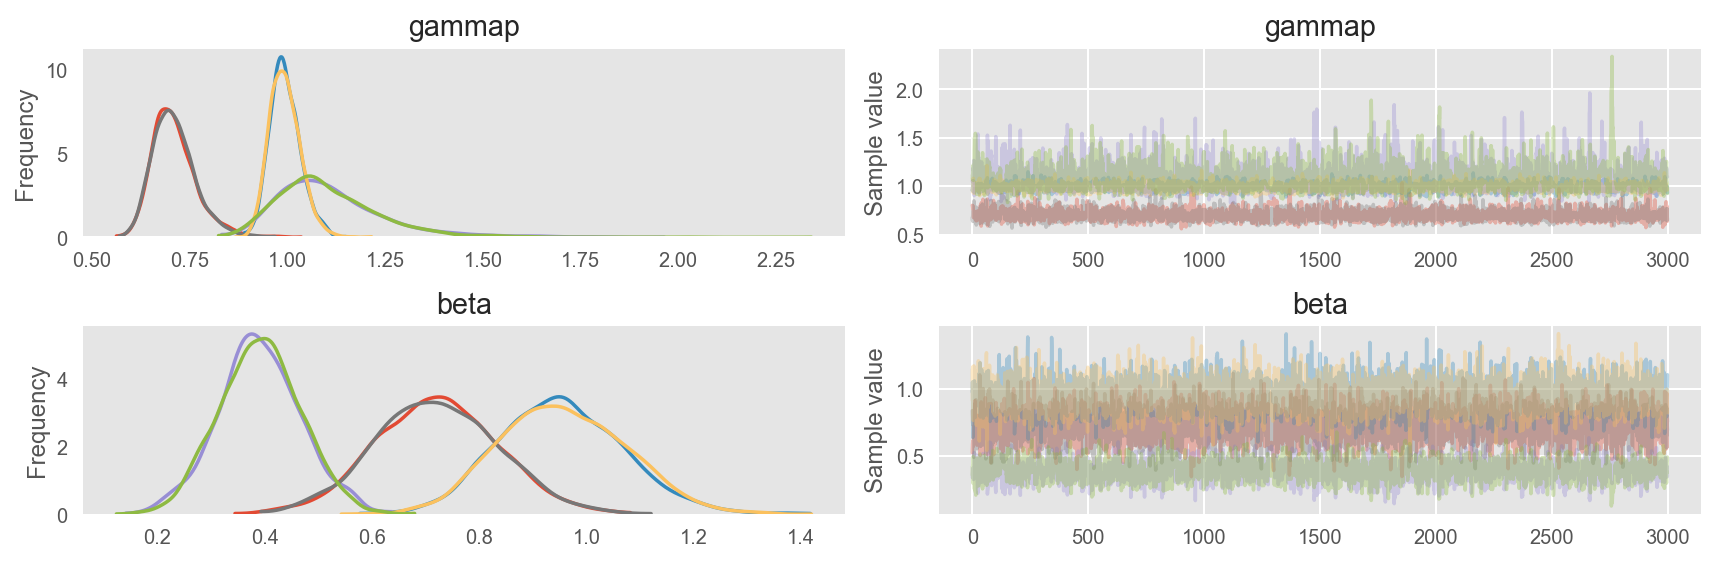

In [6]:
with pm.Model():
    mu_g = pm.Uniform('mu_g', lower=0, upper=10)
    sigma_g = pm.Uniform('sigma_g', lower=0, upper=10)
    mu_b = pm.Uniform('mu_b', lower=0, upper=10)
    sigma_b = pm.Uniform('sigma_b', lower=0, upper=10)
    
    gammap = pm.Normal('gammap', mu=mu_g, sd=sigma_g, shape=Ncond)
    beta = pm.Normal('beta', mu=mu_b, sd=sigma_b, shape=Ncond)
    
    omega = -gammap[cij]/np.log(1-p)
    thetajk = 1 - pm.math.invlogit(- beta[cij] * (kij - omega))
    
    djk = pm.Bernoulli("djk", p=thetajk, observed=dij)
        
    trace2 = pm.sample(3e3, njobs=2)
    
pm.traceplot(trace2, varnames=['gammap', 'beta'])
plt.show()

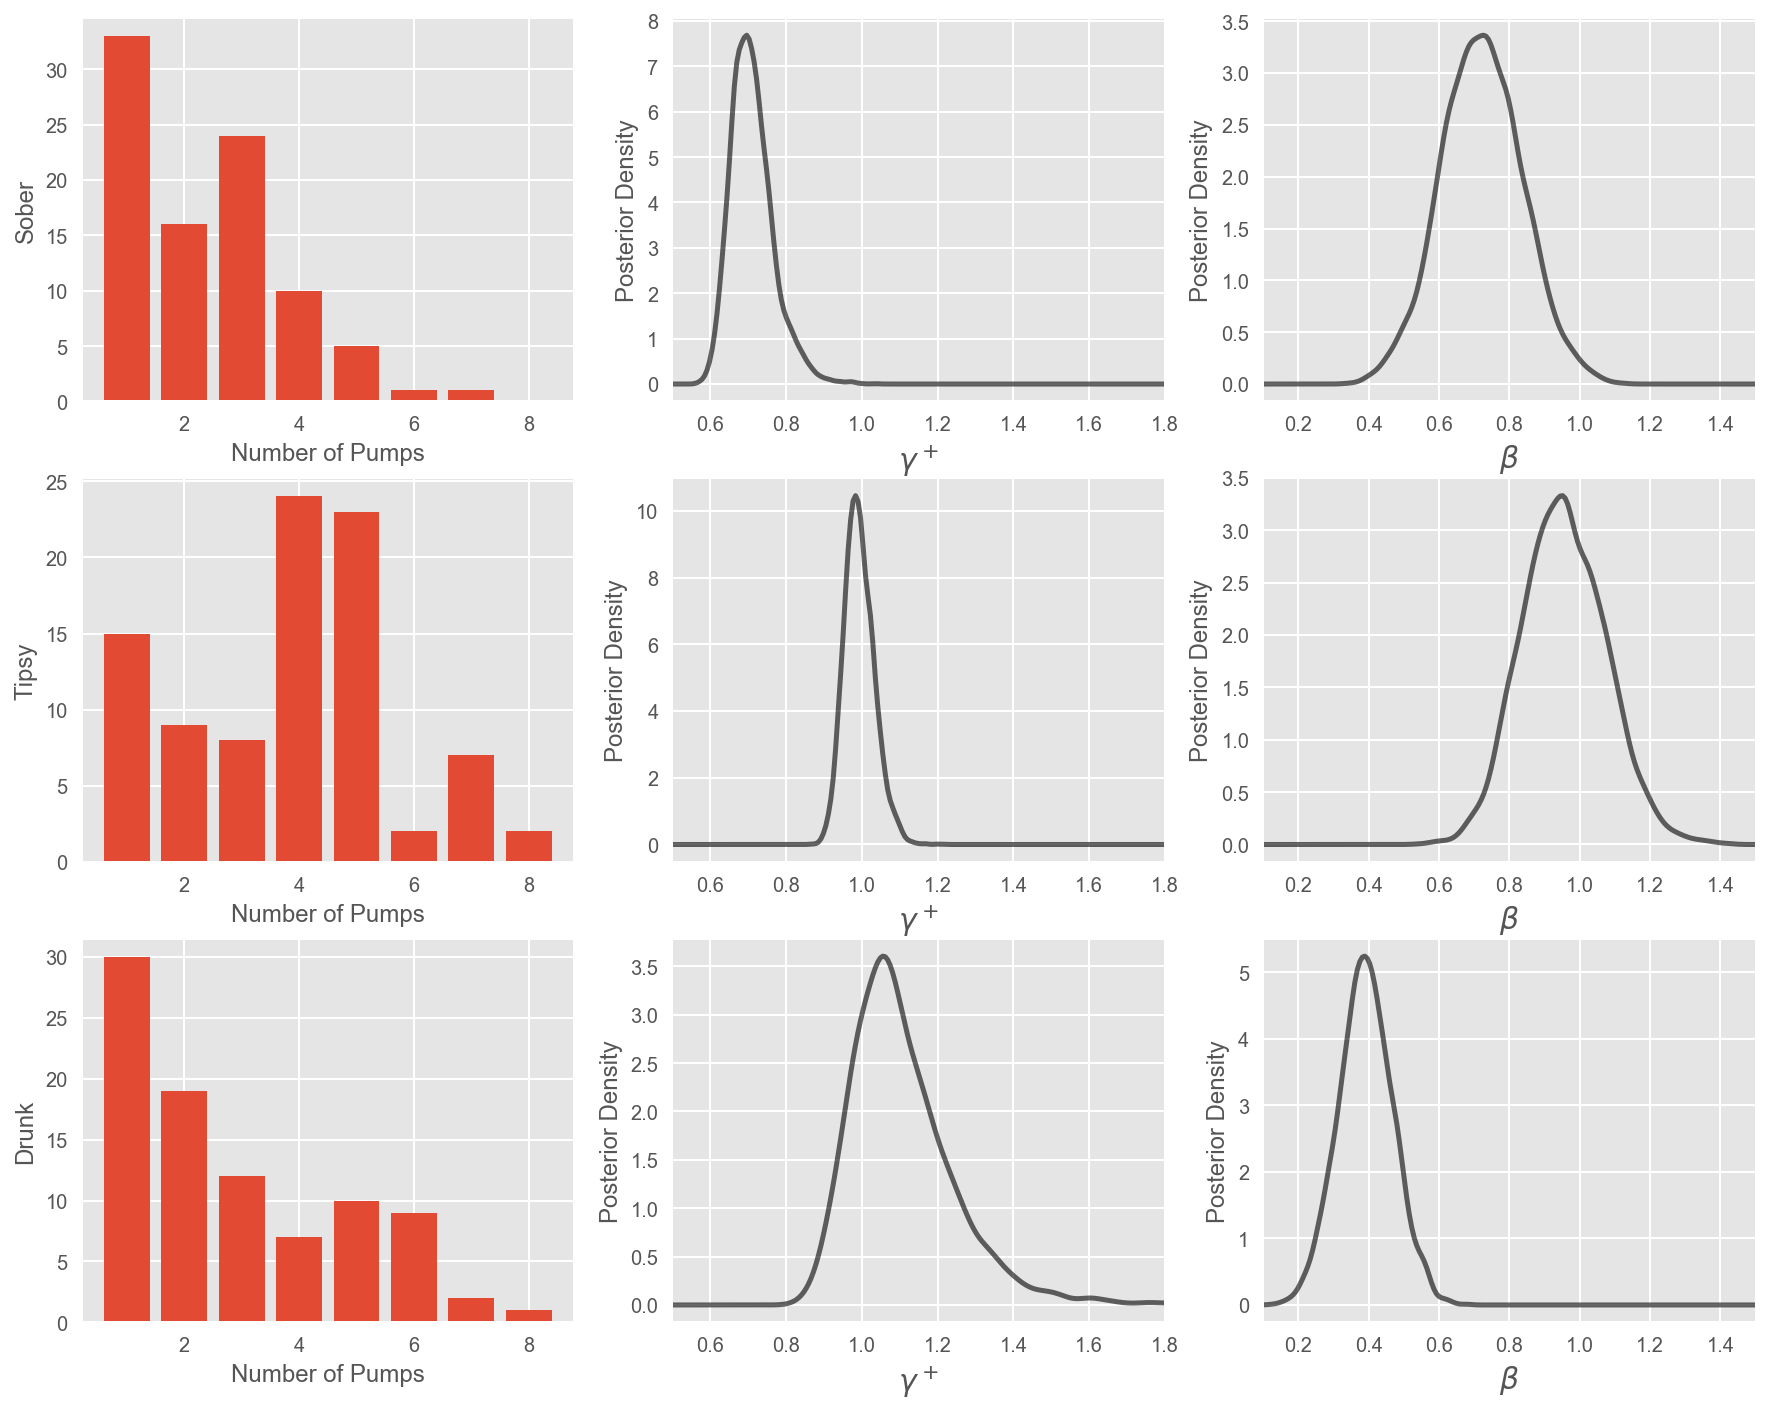

In [8]:
burnin=1000
gammaplus = trace2['gammap'][burnin:]
beta = trace2['beta'][burnin:]
ylabels = ['Sober', 'Tipsy', 'Drunk']

fig = plt.figure(figsize=(15, 12))
gs = gridspec.GridSpec(3, 3)
for ic in range(Ncond):
    
    ax0 = plt.subplot(gs[0+ic*3])
    ax0.hist(npumps_[ic], bins=range(1, 10), rwidth=.8, align='left')
    plt.xlabel('Number of Pumps', fontsize=12)
    plt.ylabel(ylabels[ic], fontsize=12)

    ax1 = plt.subplot(gs[1+ic*3])
    my_pdf1 = gaussian_kde(gammaplus[:, ic])
    x1=np.linspace(.5, 1.8, 200)
    ax1.plot(x1, my_pdf1(x1), 'k', lw=2.5, alpha=0.6) # distribution function
    plt.xlim((.5, 1.8))
    plt.xlabel(r'$\gamma^+$', fontsize=15)
    plt.ylabel('Posterior Density', fontsize=12)

    ax2 = plt.subplot(gs[2+ic*3])
    my_pdf2 = gaussian_kde(beta[:, ic])
    x2=np.linspace(0.1, 1.5, 200)
    ax2.plot(x2, my_pdf2(x2), 'k', lw=2.5, alpha=0.6) # distribution function
    plt.xlim((0.1, 1.5))
    plt.xlabel(r'$\beta$', fontsize=15)
    plt.ylabel('Posterior Density', fontsize=12)

plt.show()